In [6]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate_nn as srnn
import surrogate1 as sr1
import surrogate as sr
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
import sample as sm
import hr_restrict as hrr
import time
from torch.autograd.functional import jacobian
from torchdiffeq import odeint as odeint
from scipy.fft import fft, fftfreq
from scipy.linalg import dft
import seaborn as sns

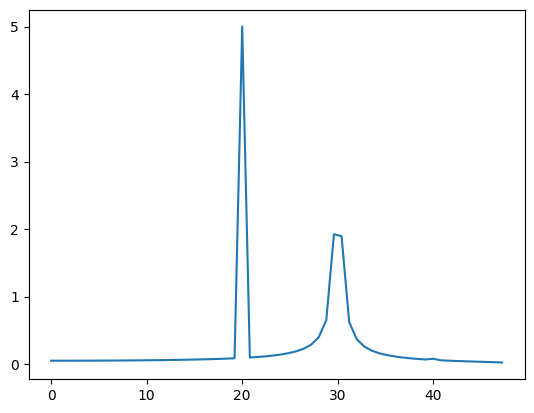

In [2]:
np.random.seed(28)
def get_func(n1, n2):
    n = np.random.randint(n2, size=n1)
    a_n = np.random.normal(size=n1)
    b_n = np.random.normal(size=n1)
    return lambda x: np.array([a_n[i]*np.cos(n_*x) + b_n[i]*np.sin(n_*x) for i, n_ in enumerate(n)]).sum(axis=0)

yr = get_func(3, 10)
x = np.linspace(-np.pi, np.pi, 1000)

pi2 = 2*np.pi
y = lambda x:  5*np.sin(pi2*20*x) + 3*np.sin(pi2*30*x) + 0.1*np.sin(pi2*50*x) + 0.05*np.sin(pi2*40*x)
# Number of sample points
N = 1000
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)
yf = fft(y(x))
xf = fftfreq(N, T)[:60]
plt.plot(xf, 2.0/N * np.abs(yf[:60]))

In [12]:
x = np.linspace(0., 0.2, int(1e6))
fx = y(x)
N = 20000
idx = np.sort(np.random.choice(len(x), size=N))
train_x = x[idx].reshape(1, -1)
train_y = fx[idx].reshape(1, -1)

sampler = hrr.GoodRowSampler(0.4, 3.5, train_x)
ms = sm.MatrixSampler(0.4, 3.5, train_x.T)

D_r=300
beta = 4e-9
# random feature map
Wins, bins = ms.sample([D_r-int(D_r/2), 0, int(D_r/2)], 1)
rf = sr.SurrogateModel_LR(D=3, D_r=D_r, W_in_fn=Wins[0], b_in_fn=bins[0])
rf.compute_W_xy(train_x, train_y, beta)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

rf_y = rf.forecast_m(train_x).flatten()
ax1.scatter(train_x.flatten(), rf_y, s=1, label='RFM')
ax1.scatter(train_x.flatten(), train_y.flatten(), s=1, label='signal')
ax1.legend()
T = 1/1000
N = 50
rf_x = np.linspace(0.0, N*T, N, endpoint=False).reshape(1, -1)
rf_y = rf.forecast_m(rf_x).flatten()
yf = fft(rf_y)#fft(y(rf_x.flatten()))
xf = fftfreq(N, T)[:N//10]
ax2.plot(xf, 2.0/N * np.abs(yf[:N//10]), label='RFM')
ax2.set_xlabel('frequency')
ax2.legend()

KeyboardInterrupt: 

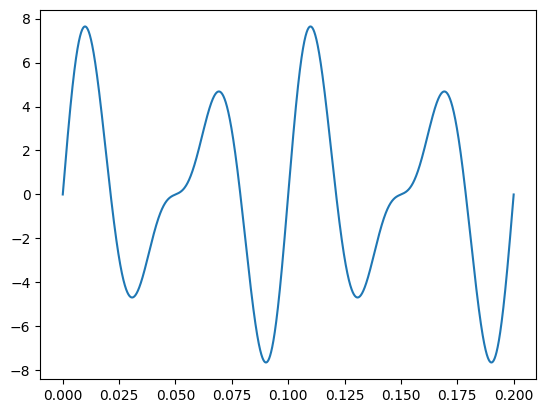

In [5]:
plt.plot(x, y(x))

In [4]:
network = srnn.SurrogateModel_NN(D=1, D_r=300, save_folder='../data/func-approx')
log_interval = 100
save_interval = 1000
update_frequency = 100
min_change = (1-0.01)**(1./log_interval) - 1.
network.learn_xy(train_x, train_y, beta=4e-9, learning_rate=1e-4, steps=10000, batch_size=100,\
                 max_delta=0.1, min_change=min_change, constant_rate=False, update_frequency=update_frequency, mode='simple-random')

step: 0 loss: 1815.052494 time: 0.0021 lr: 0.000100,  change: nan%
step: 100 loss: 2078.051171 time: 0.0764 lr: 0.000100,  change: 14.49%
--------------------------------------------------------------
             Attempting to decrease learning rate             
--------------------------------------------------------------
step: 200 loss: 2008.473167 time: 0.1470 lr: 0.000090,  change: 10.66%
--------------------------------------------------------------
             Attempting to decrease learning rate             
--------------------------------------------------------------
step: 300 loss: 1611.519476 time: 0.2175 lr: 0.000087,  change: -11.21%
step: 400 loss: 1652.642746 time: 0.2886 lr: 0.000087,  change: 2.55%
--------------------------------------------------------------
             Attempting to decrease learning rate             
--------------------------------------------------------------
step: 500 loss: 1680.705236 time: 0.3593 lr: 0.000080,  change: 4.29%
------------

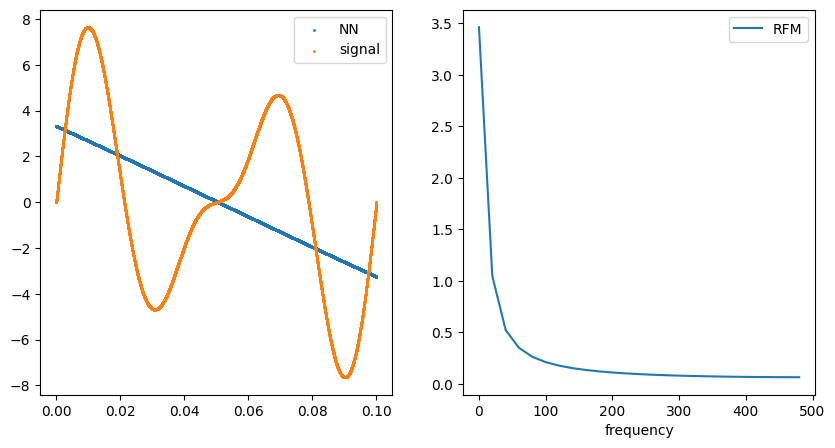

In [7]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

network_y = network.net(torch.from_numpy(train_x.T)).detach().numpy().flatten()
ax1.scatter(train_x.flatten(), network_y, s=1, label='NN')
ax1.scatter(train_x.flatten(), train_y, s=1, label='signal')
ax1.legend()
T = 1/1000
N = 50
network_x = np.linspace(0.0, N*T, N, endpoint=False).reshape(1, -1)
network_y = network.net(torch.from_numpy(network_x.T)).detach().numpy().flatten()
yf = fft(network_y)#fft(y(network_x.flatten()))
xf = fftfreq(N, T)[:N//2]
ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]), label='RFM')
ax2.set_xlabel('frequency')
ax2.legend()

In [6]:
network = srnn.SurrogateModel_NN_multi(D=1, D_r=300, save_folder='../data/func-approx-multi')
log_interval = 100
save_interval = 1000
update_frequency = 100
min_change = (1-0.01)**(1./log_interval) - 1.
network.learn_xy(train_x, train_y, beta=0., learning_rate=1e-5, steps=1000, batch_size=1000,\
                 max_delta=0.1, min_change=min_change, constant_rate=True, update_frequency=update_frequency, mode='simple-random')

step: 0 loss: 17339.694955 time: 0.0161 lr: 0.000010,  change: nan%
step: 100 loss: 17009.951373 time: 1.4354 lr: 0.000010,  change: -1.90%
step: 200 loss: 17582.197767 time: 2.8411 lr: 0.000010,  change: 3.36%
step: 300 loss: 16577.074447 time: 4.2523 lr: 0.000010,  change: -2.54%
step: 400 loss: 16303.044181 time: 5.6753 lr: 0.000010,  change: -1.65%
step: 500 loss: 15958.967471 time: 7.0982 lr: 0.000010,  change: -2.11%
step: 600 loss: 16426.537356 time: 8.5312 lr: 0.000010,  change: 2.93%
step: 700 loss: 16398.566374 time: 9.9498 lr: 0.000010,  change: 2.75%
step: 800 loss: 16576.202664 time: 11.3916 lr: 0.000010,  change: 3.87%
step: 900 loss: 15522.390557 time: 12.8294 lr: 0.000010,  change: -2.74%
Time taken by learn_xy is 14.3764 seconds


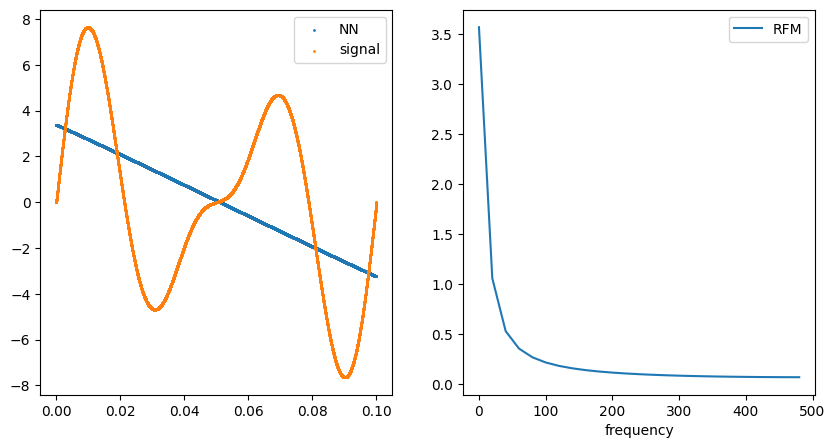

In [7]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

network_y = network.net(torch.from_numpy(train_x.T)).detach().numpy().flatten()
ax1.scatter(train_x.flatten(), network_y, s=1, label='NN')
ax1.scatter(train_x.flatten(), train_y, s=1, label='signal')
ax1.legend()
T = 1/1000
N = 50
network_x = np.linspace(0.0, N*T, N, endpoint=False).reshape(1, -1)
network_y = network.net(torch.from_numpy(network_x.T)).detach().numpy().flatten()
yf = fft(network_y)#fft(y(network_x.flatten()))
xf = fftfreq(N, T)[:N//2]
ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]), label='RFM')
ax2.set_xlabel('frequency')
ax2.legend()

In [4]:
network = srnn.SurrogateModel_NN_multi_bn(D=1, D_r=300, save_folder='../data/func-approx-multi-bn')
log_interval = 100
save_interval = 1000
update_frequency = 100
min_change = (1-0.01)**(1./log_interval) - 1.
network.learn_xy(train_x, train_y, beta=0., learning_rate=1e-5, steps=10000, batch_size=1000,\
                 max_delta=0.1, min_change=min_change, constant_rate=True, update_frequency=update_frequency, mode='simple-random')

step: 0 loss: 17568.221954 time: 0.0239 lr: 0.000010,  change: nan%
step: 100 loss: 8374.351604 time: 2.2167 lr: 0.000010,  change: -52.33%
step: 200 loss: 5833.516013 time: 3.9797 lr: 0.000010,  change: -30.34%
step: 300 loss: 5439.897912 time: 5.7610 lr: 0.000010,  change: -6.75%
step: 400 loss: 2319.003908 time: 7.5304 lr: 0.000010,  change: -57.37%
step: 500 loss: 3505.578863 time: 9.3056 lr: 0.000010,  change: 51.17%
step: 600 loss: 1967.664787 time: 11.0808 lr: 0.000010,  change: -15.15%
step: 700 loss: 2088.915166 time: 12.8470 lr: 0.000010,  change: 6.16%
step: 800 loss: 1677.731618 time: 14.6110 lr: 0.000010,  change: -14.73%
step: 900 loss: 1820.424159 time: 16.3995 lr: 0.000010,  change: 8.51%
step: 1000 loss: 1469.290280 time: 18.2308 lr: 0.000010,  change: -12.42%
step: 1100 loss: 1014.956471 time: 20.0902 lr: 0.000010,  change: -30.92%
step: 1200 loss: 765.502163 time: 21.8749 lr: 0.000010,  change: -24.58%
step: 1300 loss: 11813.099502 time: 23.6562 lr: 0.000010,  change

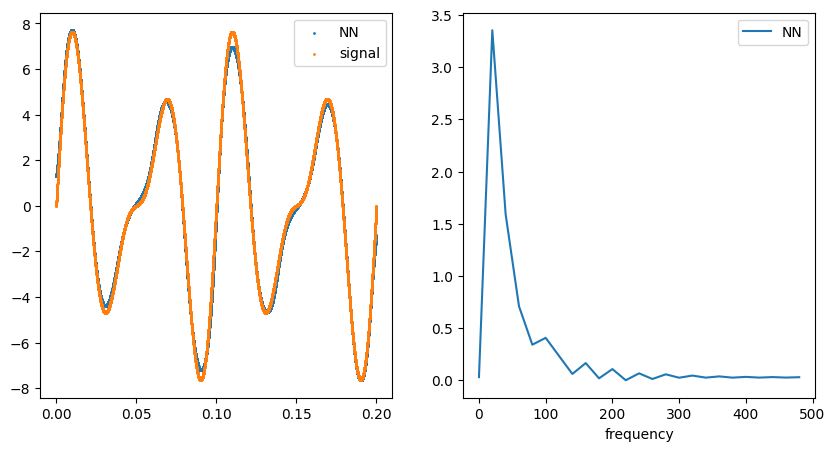

In [5]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

network_y = network.net(torch.from_numpy(train_x.T)).detach().numpy().flatten()
ax1.scatter(train_x.flatten(), network_y, s=1, label='NN')
ax1.scatter(train_x.flatten(), train_y, s=1, label='signal')
ax1.legend()
T = 1/1000
N = 50
network_x = np.linspace(0.0, N*T, N, endpoint=False).reshape(1, -1)
network_y = network.net(torch.from_numpy(network_x.T)).detach().numpy().flatten()
yf = fft(network_y)#fft(y(network_x.flatten()))
xf = fftfreq(N, T)[:N//2]
ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]), label='NN')
ax2.set_xlabel('frequency')
ax2.legend()

In [18]:
rf.final_loss, network.loss_fn(torch.from_numpy(train_x.T), torch.from_numpy(train_y.T), beta)

(135217.56371393046, tensor(36504.0551, grad_fn=<AddBackward0>))

In [9]:
network = srnn.SurrogateModel_NN_bn(D=1, D_r=300, save_folder='../data/func-approx-bn')
log_interval = 100
save_interval = 1000
update_frequency = 100
min_change = (1-0.01)**(1./log_interval) - 1.
network.learn_xy(train_x, train_y, beta=0., learning_rate=1e-5, steps=10000, batch_size=1000,\
                 max_delta=0.1, min_change=min_change, constant_rate=True, update_frequency=update_frequency, mode='simple-random')

step: 0 loss: 17159.729357 time: 0.0152 lr: 0.000010,  change: nan%
step: 100 loss: 16965.448118 time: 0.4551 lr: 0.000010,  change: -1.13%
step: 200 loss: 16265.683123 time: 0.9294 lr: 0.000010,  change: -4.12%
step: 300 loss: 15322.531686 time: 1.4019 lr: 0.000010,  change: -5.80%
step: 400 loss: 16330.558401 time: 1.8728 lr: 0.000010,  change: 6.58%
step: 500 loss: 16489.391966 time: 2.3453 lr: 0.000010,  change: 7.62%
step: 600 loss: 16010.258557 time: 2.8164 lr: 0.000010,  change: 4.49%
step: 700 loss: 16177.778995 time: 3.2866 lr: 0.000010,  change: 5.58%
step: 800 loss: 15054.137268 time: 3.6992 lr: 0.000010,  change: -1.75%
step: 900 loss: 16022.310318 time: 4.1708 lr: 0.000010,  change: 6.43%
step: 1000 loss: 16103.451574 time: 4.6405 lr: 0.000010,  change: 6.97%
step: 1100 loss: 15690.610204 time: 5.1112 lr: 0.000010,  change: 4.23%
step: 1200 loss: 15525.219319 time: 5.5809 lr: 0.000010,  change: 3.13%
step: 1300 loss: 15951.837209 time: 6.0517 lr: 0.000010,  change: 5.96%
s

KeyboardInterrupt: 

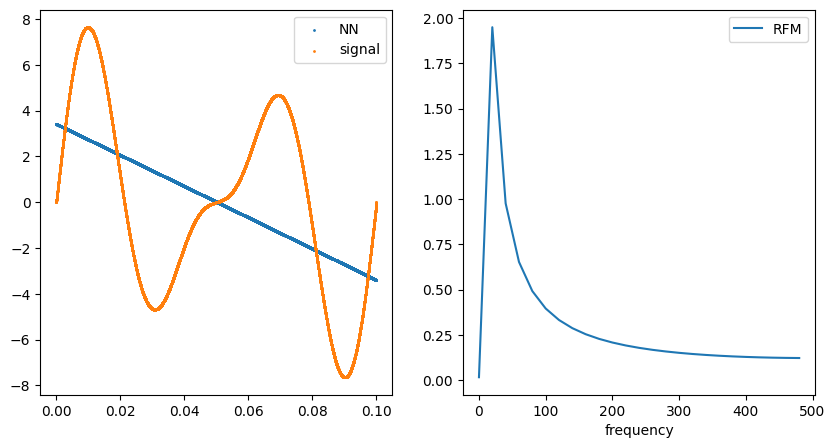

In [8]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

network_y = network.net(torch.from_numpy(train_x.T)).detach().numpy().flatten()
ax1.scatter(train_x.flatten(), network_y, s=1, label='NN')
ax1.scatter(train_x.flatten(), train_y, s=1, label='signal')
ax1.legend()
T = 1/1000
N = 50
network_x = np.linspace(0.0, N*T, N, endpoint=False).reshape(1, -1)
network_y = network.net(torch.from_numpy(network_x.T)).detach().numpy().flatten()
yf = fft(network_y)#fft(y(network_x.flatten()))
xf = fftfreq(N, T)[:N//2]
ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]), label='RFM')
ax2.set_xlabel('frequency')
ax2.legend()

In [17]:
ms = sm.MatrixSampler(0.4, 3.5, train_x.T)
w,  b = ms.sample([20, 0, 20], 1)

KeyboardInterrupt: 

In [19]:
train_x.T.shape

(20000, 1)